# Online Clustering: PACO algorithm

In [1]:
from math import *
import numpy as np
import random
import pandas as pd
from sklearn.cluster import KMeans
from scipy.special import gamma
from numpy.linalg import slogdet
from math import inf
%matplotlib inline
import matplotlib.pyplot as plt


## Model 6: 10 mixed groups in dimension 2

In [2]:
def unit_cercle(circle_r,circle_x,circle_y):
    # random angle
    alpha = 2 * pi * random.random()
    # random radius
    r = circle_r * random.random()
    # calculating coordinates
    x = r * cos(alpha) + circle_x
    y = r * sin(alpha) + circle_y
    return x,y

T=200
x=list()
for t in range(1,T+1):
    if t<=100:
        c1=(20/9)*int((t-1)/20)
        c2=10*sin(c1*pi/10)
        x.append(unit_cercle(1,c1,c2))

    else:
        c1=20/9*int((t-1)/20)
        c2=10*sin(c1*pi/10)
        mean=[c1,c2]
        cov = [[1, 0], [0, 1]]
        x.append(np.random.multivariate_normal(mean, cov , 1)[0])
    
x=np.asarray(x)    
print(x)
  

## Functions

In [4]:
def kmeans(X,Nclusters):
    kmeans = KMeans(n_clusters=Nclusters, max_iter=10).fit(X)
    return kmeans.cluster_centers_

def multivariate_t(S,mean, df=3, n=1):
    
    #generate random variables of multivariate t distribution
    d = len(mean)
    x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return mean + z/np.sqrt(x)[:,None]   

def runiform_ball(n, d, R): 
    
    simulations = np.zeros((n,d))
    for i in range(0,n) :
        simul = np.random.uniform(-R,R,(1,d))[0]
        while sqrt(sum(simul**2)) > R:
            simul = np.random.uniform(-R,R,(1,d))[0]
        
        simulations[i] = simul
    
    return(simulations)

def instantaneous_loss(centers, instant_observation): 

    if (type(centers) != np.ndarray):
        return(sum((centers - instant_observation)**2))
    
    else :
        replicate_instant_observation = np.repeat(np.asarray([instant_observation]),len(centers),axis=0)
        distances=np.apply_along_axis(sum,1,(centers - replicate_instant_observation)**2)
        return(min(distances))
    
def transition_prob(x,z,K_max,prob=1/3):
    
    if (x > K_max) or (z > K_max) or (x < 1) or (z < 1):
        q=0
    else:
        if x==1:
            q = 0.5 * ((z == 1) or (z == 2))
        else:
            if x==z:
                q=prob
            else:
                q=(1 - prob)/2 * ((x < z and z < (x + 2)) or (z < x and (z > (x - 2))))
            
    return (q)

def multivariate_student_d(X, mean, Sigma, df):    
    #multivariate student T distribution

    [n,d] = X.shape
    Xm = X-mean
    V = df * Sigma
    V_inv = np.linalg.inv(V)
    (sign, logdet) = slogdet(np.pi * V)

    logz = -gamma(df/2.0 + d/2.0) + gamma(df/2.0) + 0.5*logdet
    logp = -0.5*(df+d)*np.log(1+ np.sum(np.dot(Xm,V_inv)*Xm,axis=1))

    logp = logp - logz            

    return logp

def multivariate_student(X,mean,Sigma,df,d):

    #Multivariate t-student density:
    Num = gamma(1. * (d+df)/2)
    Denom = ( gamma(1.*df/2) * pow(df*pi,1.*d/2) * pow(np.linalg.det(Sigma),1./2) * pow(1 + (1./df)*np.dot(np.dot((X - mean),np.linalg.inv(Sigma)), (X - mean)),1.* (d+df)/2))
    d = 1. * Num / Denom 
    return log(d)



## PACO algorithm

In [5]:
def PACO_new(data, R, p = 50, N_iterations = 500): 
    if (R < max(np.sqrt(np.sum(data**2,axis=1)))):
        print("R should be bigger than the maximum Euclidean distance of observations")
    else:
        d = data.shape[1] 
        T = data.shape[0] 
        
        def lamda_1(t):
            return 2.5 * 2 *(d + 2) * (t-1)**(-0.5)/R

        def lamda_2(t):
            return (d + 2) * (t)**(-0.5)/R**4
        lambda_1 = np.repeat(1., T)
        lambda_1[1:T] = np.apply_along_axis(lamda_1, 0, range(2,T+1))
        lambda_2 = np.apply_along_axis(lamda_2, 0, range(1,T+1))
        Nclusters = np.repeat(1,N_iterations)
        cumul_loss = np.repeat(0.,N_iterations)
        nb_of_clusters = np.repeat(1, T)
        predicted_centers = list()
        predicted_loss = np.repeat(0., T)
        loss = np.repeat(0., T)
        c_0 = runiform_ball(3000, d, R)
        which=lambda lst:list(np.where(lst)[0])
        index = which(np.apply_along_axis(sum,1,(c_0 - np.repeat(np.asarray([data[0]]),3000,axis=0))**2) == instantaneous_loss(c_0,data[0]))
        predicted_centers.append(c_0[index])
        predicted_loss[0] = instantaneous_loss(predicted_centers[0],data[0])
        
        #Time iteration
        for t in range(2,T+1):
            kmeans_output=[]
            N_predicted_centers=[]
            tau = (p * t * d)**(-0.5)
            Nclusters[0] = nb_of_clusters[t - 2]  
            # Initialization 
            kmeans_output.append(kmeans(data[0:t],Nclusters[0]))
            N_predicted_centers.append(np.array([multivariate_t(S=tau*np.identity(d),mean=x, df=3, n=1) for x in kmeans_output[0]]).reshape(Nclusters[0],d)) 

            while (sum(np.sqrt(np.sum(N_predicted_centers[0]**2, axis=1)) > R) > 0):
                
                N_predicted_centers[0]= np.array([multivariate_t(S=tau*np.identity(d),mean=x, df=3, n=1)
                                            for x in kmeans_output[0]]).reshape(Nclusters[0],d)
        
            loss[0:t]=np.array([instantaneous_loss(N_predicted_centers[0],data) for data in data[0:t]])
            cumul_loss[0] = sum(loss[0:t]) + 0.5 * sum(lambda_2 * (loss - predicted_loss)**2)
            
            #RJMCMC iteration
            for n in range(1,N_iterations):
                
                loss_temp=np.repeat(0., T)
                
                q = np.array([transition_prob(Nclusters[n - 
                    1], Nclusters[n - 1] - 1, p), transition_prob(Nclusters[n - 
                    1], Nclusters[n - 1], p), transition_prob(Nclusters[n - 
                    1], Nclusters[n - 1] + 1, p)])
                q = q/sum(q)
                new_k = np.random.choice(np.array([Nclusters[n - 1] - 1, Nclusters[n -1], Nclusters[n - 1] + 1]),
                                       size=1, replace=True, p=q)[0]
                if(new_k == Nclusters[n - 1]):
                    
                    mean = kmeans_output[n-1]
                else:
                    if(new_k >= t - 1):
                        
                        new_k = t - 1 
                        mean = data[0:t]
                    else:
                        mean = kmeans(data[0:t],new_k)
            
                c_prime = np.array([multivariate_t(S=tau*np.identity(d),mean=x, df=3, n=1)
                                            for x in mean]).reshape(len(mean),d)
                
                #RJMCMC acceptance probability
                if sum(np.sqrt(np.sum(c_prime**2, axis=1)) < R) == new_k:
                    
                    log_rho_numerator = np.array([multivariate_student_d(X=N_predicted_centers[n -1][l].reshape(1,d),
                        mean=kmeans_output[n - 1][l],
                        Sigma= tau*np.identity(d), df=3) for l in range(0,Nclusters[n-1])]).reshape(Nclusters[n-1],)
                    log_rho_denominator=np.array([multivariate_student_d(X=c_prime[l].reshape(1,d),
                        mean=mean[l],Sigma= tau*np.identity(d), df=3) for l in np.arange(0,new_k)]).reshape(new_k,)
                    log_numerator_prior = np.repeat(log(gamma(d/2 + 1))- (d/2)*log(pi)- d* log(R),
                                                     new_k)
                    log_denominator_prior = np.repeat(log(gamma(d/2 + 1))- (d/2)*log(pi)- d* log(R),
                                                     Nclusters[n - 1])
                    loss_temp[0:t]= np.array([instantaneous_loss(c_prime,data)
                        for data in data[0:t]])
                    N_cumul_loss = sum(loss_temp) + 0.5 * sum(lambda_2 * (loss_temp - 
                        predicted_loss)**2)
                    rjmcmc = -lambda_1[t - 2] * (N_cumul_loss - cumul_loss[n - 1]) + sum(np.concatenate((log_numerator_prior,log_rho_numerator)) - np.concatenate((log_denominator_prior,log_rho_denominator))) + log(transition_prob(new_k, Nclusters[n - 1], p)) - log(transition_prob(Nclusters[n - 1],new_k, p))
            
                else:
                    rjmcmc = -inf
                
                if log(np.random.uniform()) < rjmcmc:
                    N_predicted_centers.append(c_prime)
                    kmeans_output.append(mean)
                    Nclusters[n] = new_k
                    cumul_loss[n] = N_cumul_loss
                else:
                    N_predicted_centers.append(N_predicted_centers[n - 1])
                    kmeans_output.append(kmeans_output[n - 1])
                    Nclusters[n] = Nclusters[n - 1]
                    cumul_loss[n] = cumul_loss[n - 1]
            
            
            nb_of_clusters[t-1] = Nclusters[N_iterations-1]
            predicted_centers.append(N_predicted_centers[N_iterations-1])
            predicted_loss[t-1] = instantaneous_loss(predicted_centers[t-1],data[t-1])
                
        return [predicted_centers[T-1], nb_of_clusters]

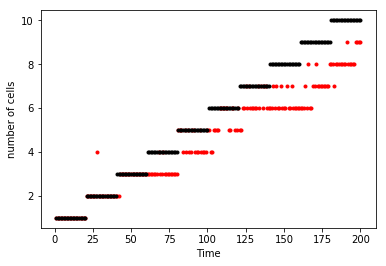

In [6]:
R=max(np.sqrt(np.sum(x**2,axis=1)))
true_value=np.array(np.repeat(range(1,11),20))
T=range(1,201)
result=PACO_new(x, R, p = 50, N_iterations = 20)
plt.plot(T,result[1],'.',color='red', label='predictions')
plt.plot(T,true_value,'.',color='black', label='true values')
plt.xlabel('Time')
plt.ylabel('number of cells')
plt.axis('tight')
plt.show()